## 경사하강법으로 이미지 복원하기
- 프로젝트 개요
  - 이미지 처리를 위해 만들어 두었던 weird_function() 함수에 실수로 버그가 들어가 100×100 픽셀의 오염된 미미지가 만들어졌다. 
  - 이 오염된 이미지와 오염되기 전 원본 이미지를 동시에 파일로 저장하려고 했으나, 모종의 이유로 원본 이미지 파일은 삭제된 상황이다. 
  - 다행히 weird_function()의 소스코드는 남아 있다. 
  - 오염된 이미지와 weird_function()을 활용해 원본 이미지를 복원해보자.
####<br>
- 일반적인 접근 방법
  1. weird_function() 함수의 소스코드 분석
  2. 분석을 토대로 weird_function() 함수의 동작을 반대로 이행하는 함수 구현
  3. 2에서 구현한 함수에 오염된 이미지를 입력한 후, 복구된 이미지 출력
####<br>
- 머신러닝 방식의 접근 방법(사고 방법)
  1. 오염된 이미지와 같은 크기의 랜덤 텐서를 생성한다.
  2. 랜덤 텐서를 weird_function() 함수에 입력해 똑같이 오염된 이미지를 가설이라고 부른다.
    - (사실) 원본 이미지가 weird_function() 함수에 입력되어 오염된 이미지를 출력했다.
    - (사실) 인위적으로 생성한 무작위 이미지가 weird_function() 함수에 입력되어 가설을 출력했다.
  3. 가설과 오염된 이미지가 같다면 무작위 이미지와 원본 이미지도 같을 것이다.
  4. 그러므로 weird_function(random_tensor) = broken_image 관계가 성립하도록 만든다.

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_PATH = '/content/drive/MyDrive/2022/딥러닝/자연어처리/실습자료/data/'

In [ ]:
import torch
import pickle
import matplotlib.pyplot as plt

In [ ]:
shp_original_img = (100, 100)
filepath = '{}{}'.format(ROOT_PATH, 'broken_image_t.p')
broken_image =  torch.FloatTensor( pickle.load(open(filepath, 'rb'),encoding='latin1' ) )

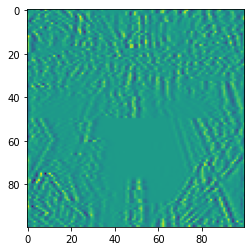

In [ ]:
plt.imshow(broken_image.view(100,100)) 

In [ ]:
def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

In [ ]:
def distance_loss(hypothesis, broken_image):    
    return torch.dist(hypothesis, broken_image)

In [ ]:
random_tensor = torch.randn(10000, dtype = torch.float)

In [ ]:
lr = 0.8
for i in range(0,20000): # 2만번을 돌리겠다.
    random_tensor.requires_grad_(True) # 미분을 하겠다.
    hypothesis = weird_function(random_tensor)
    loss = distance_loss(hypothesis, broken_image)
    loss.backward()
    with torch.no_grad(): # backward를 하는 도중에 잠시 멈춰서 출력을 하기 위해 사용
        random_tensor = random_tensor - lr*random_tensor.grad #차이의 값을 random_tensor로 지정
    if i % 1000 == 0: # 1000번 단위로 출력한다.
        print('Loss at {} = {}'.format(i, loss.item()))

Loss at 0 = 12.126800537109375
Loss at 1000 = 1.1466094255447388
Loss at 2000 = 0.556459903717041
Loss at 3000 = 0.38134264945983887
Loss at 4000 = 0.2983401417732239
Loss at 5000 = 0.24804097414016724
Loss at 6000 = 0.21228499710559845
Loss at 7000 = 0.18414457142353058
Loss at 8000 = 0.1604909896850586
Loss at 9000 = 0.1397027224302292
Loss at 10000 = 0.12084589153528214
Loss at 11000 = 0.1033397689461708
Loss at 12000 = 0.08680394291877747
Loss at 13000 = 0.07098081707954407
Loss at 14000 = 0.055692873895168304
Loss at 15000 = 0.040817636996507645
Loss at 16000 = 0.026273120194673538
Loss at 17000 = 0.021158525720238686
Loss at 18000 = 0.0211658738553524
Loss at 19000 = 0.02116740308701992


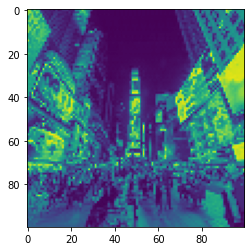

In [ ]:
plt.imshow(random_tensor.view(100,100).data)

## 2-3. 신경망 모델 구현하기

In [ ]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [ ]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

In [ ]:
def label_map(y_, from_, to_): # 딥러닝을 하기 위해서 매핑을 해야 한다.
    y = numpy.copy(y_) # 원본에 적용하지 않기 위해 copy
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

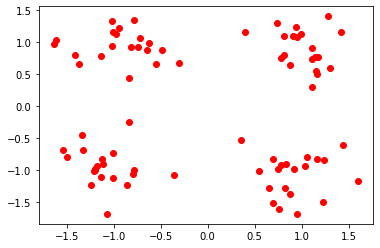

In [ ]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [ ]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])


In [ ]:
class NeuralNet(torch.nn.Module): # pyTorch 내의 Module 이용하여 함수 선언
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size) # 선형 Layer 먼저 만듦
        self.relu = torch.nn.ReLU() 
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_tensor): #
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output

In [ ]:
model = NeuralNet(2, 5) # input size 2 hidden_size 5
learning_rate = 0.03
criterion = torch.nn.BCELoss() # 오차 계산할때 사용 BCELoss라는 함수 사용
epochs = 2000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
model.eval() # 학습 전에 
test_loss_before = criterion(model(x_test).squeeze(), y_test) # squeeze를 통해 차원 줄임
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7706235647201538


- 오차값이 0.73 이 나왔다. 
- 이정도의 오차를 가진 모델은 사실상 분류하는 능력이 없다고 봐도 무방하다.
---
- 신경망을 학습시켜 성능 향상 시키기

In [ ]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad() # 초기화를 해줘야한다. 왜?
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7664535641670227
Train loss at 100 is 0.21431711316108704
Train loss at 200 is 0.10639697313308716
Train loss at 300 is 0.06156080961227417
Train loss at 400 is 0.03637762740254402
Train loss at 500 is 0.023803194984793663
Train loss at 600 is 0.01707492396235466
Train loss at 700 is 0.013046979904174805
Train loss at 800 is 0.010415444150567055
Train loss at 900 is 0.00859068613499403
Train loss at 1000 is 0.007262068800628185
Train loss at 1100 is 0.006256338208913803
Train loss at 1200 is 0.0054732500575482845
Train loss at 1300 is 0.004849525634199381
Train loss at 1400 is 0.004342571832239628
Train loss at 1500 is 0.003922506235539913
Train loss at 1600 is 0.0035682781599462032
Train loss at 1700 is 0.00326741230674088
Train loss at 1800 is 0.003008150262758136
Train loss at 1900 is 0.0027832319028675556


In [ ]:
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.0027007232420146465


- 학습을 하기 전과 비교했을때 현저하게 줄어든 오차값을 확인할 수 있다.
---
- 학습된 모델을 .pt 파일로 저장하기

In [ ]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[ 0.7834,  0.7845],
        [-0.4308, -0.1385],
        [-0.4880, -0.3253],
        [ 0.2906, -0.2612],
        [ 0.4479, -0.3477]])), ('linear_1.bias', tensor([-0.5276,  1.8078, -0.3894, -0.4482,  0.8788])), ('linear_2.weight', tensor([[-0.5052, -1.7190,  0.2355, -0.0441, -0.9846]])), ('linear_2.bias', tensor([-1.9543]))])


- `save()` 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 model.pt 라는 파일이 생성된다. 
- 아래 코드처럼 새로운 신경망 객체에 model.pt 속의 가중치값을 입력시키는 것 또한 가능하다.

In [ ]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.0035174868535250425
